# 这个文件用来帮助我们了解 Faster R-CNN 如何调用/训练。微调

论文地址：https://arxiv.org/pdf/1506.01497

In [1]:
import torch
import torchvision
import cv2

# load faster r-cnn model
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True).cuda()

/root/miniconda3/envs/new_env/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/root/miniconda3/envs/new_env/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [2]:
# print the structure of the model
print(model)

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

/tmp/ipykernel_69213/2641202556.py:76: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('/root/autodl-tmp/APS360_Project/Machine_Learning_Outpu

boxes:
 tensor([[   15.9090,   831.4358,    89.4993,   992.2047],
        [   40.3822,   679.3637,   356.9058,   767.7531],
        [   41.5239,   680.9332,    43.8557,   754.5435],
        [    0.3613,   794.1370,   124.9519,  1024.0000],
        [  777.3190,   607.3597,   932.2657,   681.9768],
        [  119.0790,   649.2896,   120.0817,   788.7900],
        [  107.4793,   571.4213,   268.7557,   825.3789],
        [    9.5345,   880.0322,    13.5991,   934.4940],
        [   37.3172,   839.7408,    57.0599,   981.7154],
        [   29.4698,   842.0027,    41.7736,   995.5757],
        [   11.5094,   874.6716,    21.9857,   947.7960],
        [  768.4044,   735.6797,   859.0645,   865.3040],
        [   23.8620,   901.9191,    40.5779,   955.4378],
        [  248.8849,   380.7273,   271.3099,   471.5458],
        [   36.3588,   395.7045,    44.4542,   471.0186],
        [    7.9547,   892.3424,    11.4555,   931.5255],
        [  325.5688,   264.8309,   349.2674,   313.7519],
      

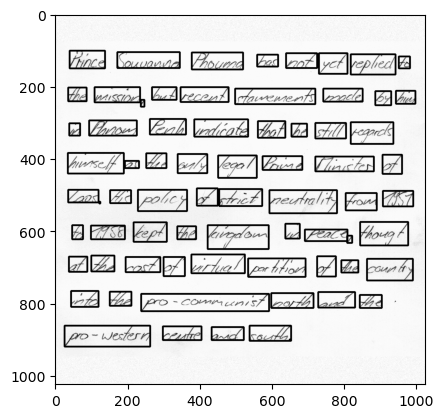

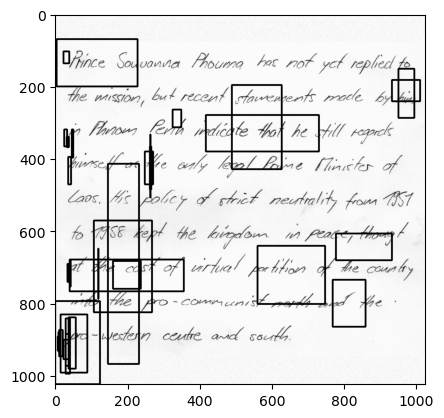

In [8]:
import torch
import torchvision.transforms as T
from PIL import Image
from PIL import ImageDraw
import matplotlib.pyplot as plt
import time

torch.set_printoptions(sci_mode=False, precision=4)

def load_image(img_path):
    img = Image.open(img_path)
    img = T.ToTensor()(img)
    img = img.unsqueeze(0)
    return img

def get_prediction(img, threshold):
    
    # put the model in evaluation mode
    model.eval()
    with torch.no_grad():
        prediction = model(img)
    
    # get the prediction box
    boxes = prediction[0]['boxes']
    labels = prediction[0]['labels']
    scores = prediction[0]['scores']
    
    # get the index of the boxes that pass the threshold
    idx = [i for i in range(len(scores)) if scores[i] > threshold]
    
    # get the boxes that pass the threshold
    boxes = boxes[idx]
    labels = labels[idx]
    scores = scores[idx]
    
    return boxes, labels, scores

def plot_image(img, boxes):
    
    # draw boxes
    # draw = ImageDraw.Draw(img)
    # for box in boxes:
    #     draw.rectangle([box[0], box[1], box[2], box[3]], outline="red", width=3)

    img = img[0]
    img -= img.min()
    img /= img.max()
    img *= 255

    # draw boxes on the image/array
    for box in boxes:
        img = cv2.rectangle(img, (int(box[0]), int(box[1])), (int(box[2]), int(box[3])), (0), 3)
    
    # plot image
    plt.imshow(img, cmap='gray')
    plt.show()

# get prediction
img_path = 'test_image.jpg'
img_path = 'test_image2.png'
threshold = 0.

from utils import *
from torchvision import transforms
dataset = ModifiedDataset(SegDataset('IAM', 'train'))
dataloader = DataLoader(dataset, batch_size=16, shuffle=True, num_workers=0, collate_fn=collate_fn)
for img, target in dataloader:
    img = img.cuda()
    break
# 加载预训练的Faster R-CNN模型
model = torchvision.models.detection.fasterrcnn_resnet50_fpn()
# 获取分类器的输入特征数
in_features = model.roi_heads.box_predictor.cls_score.in_features
# 替换预训练的头部为一个新的，只有两个类别（背景和单词）
model.roi_heads.box_predictor = torchvision.models.detection.faster_rcnn.FastRCNNPredictor(in_features, num_classes=2)
model.load_state_dict(torch.load('/root/autodl-tmp/APS360_Project/Machine_Learning_Output/Faster_R_CNN/fasterrcnn_255.pth'))
model = model.cuda()

# img = load_image(img_path).cuda()
t0 = time.time()
boxes, labels, scores = get_prediction(img, -torch.inf)
t1 = time.time()
# print('time:', t1-t0)
print("boxes:\n", boxes)
print("labels:\n", labels)
print("scores:\n", scores)
# print(target[0]['boxes'])
plot_image(img[0].cpu().numpy(), target[0]['boxes'].cpu().numpy())
plot_image(img[0].cpu().numpy(), boxes)

In [4]:
import torch
import torchvision.transforms as T
from PIL import Image
from PIL import ImageDraw
import matplotlib.pyplot as plt
import time

def load_image(img_path):
    img = Image.open(img_path)
    img = T.ToTensor()(img)
    img = img.unsqueeze(0)
    return img

def get_prediction(img, threshold):
    
    # put the model in evaluation mode
    model.eval()
    with torch.no_grad():
        prediction = model(img)
    
    return prediction

def plot_image(img_path, boxes):
    # load image
    img = Image.open(img_path)
    
    # draw boxes
    draw = ImageDraw.Draw(img)
    for box in boxes:
        draw.rectangle([box[0], box[1], box[2], box[3]], outline="red", width=3)
    
    # plot image
    plt.imshow(img)
    plt.show()

# get prediction
img_path = 'test_image.jpg'
# img_path = 'test_image2.png'
threshold = 10.
img = load_image(img_path).cuda()
t0 = time.time()
# boxes, labels, scores = get_prediction(img, threshold)
# t1 = time.time()
# print('time:', t1-t0)
# print("boxes:\n", boxes.shape)
# print("labels:\n", labels.shape)
# print("scores:\n", scores.shape)
# # print all the attributes of the model
# for i in dir(model):
#     if not i.startswith('_'):
#         print(i)
prediction = get_prediction(img, threshold)
prediction[0]['boxes'].shape

torch.Size([99, 4])

In [5]:
for chi in model.children():
    print(chi)
    print('-' * 50)

GeneralizedRCNNTransform(
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    Resize(min_size=(800,), max_size=1333, mode='bilinear')
)
--------------------------------------------------
BackboneWithFPN(
  (body): IntermediateLayerGetter(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): FrozenBatchNorm2d(64, eps=1e-05)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): FrozenBatchNorm2d(64, eps=1e-05)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): FrozenBatchNorm2d(64, eps=1e-05)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): FrozenBatchNorm2d(256, eps=1e-05)
        (relu): ReLU(inplace=True)
  

In [6]:
from utils import *

dataset = SegDataset('IAM', 'train')
dataloader = DataLoader(dataset, batch_size=32, shuffle=True, num_workers=0)

for data, label in dataloader:
    print(data.shape, label.shape)
    break

torch.Size([32, 1, 1024, 1024]) torch.Size([32, 256, 4])
